In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import astropy.units as u
from astropy.io import fits
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import copy

from importlib import reload

import poppy

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import scoobpsf
from scoobpsf.math_module import xp, _scipy
from scoobpsf.imshows import *
from scoobpsf import scoob

import lina 

pupil_diam = 6.75*u.mm 
lyot_diam = 8.6*u.mm

wavelength_c = 632.8e-9*u.m # central wavelength
npix = 256
oversample = 32
npix = 512
oversample = 16

reload(scoobpsf.agpm)
vortex = scoobpsf.agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6, singularity=20*u.um)
lyot_stop = poppy.CircularAperture(name='Lyot Stop', radius=lyot_diam/2.0)
wfs_lyot_stop = poppy.InverseTransmission(lyot_stop)


In [39]:
reload(scoob)
model = scoob.SCOOBM(npix=npix, oversample=oversample)

# static_wfe = lina.utils.generate_wfe(model.pupil_diam, wavelength=500*u.nm,
#                                     opd_index=2.75, amp_index=3.0, 
#                                     opd_seed=1234, amp_seed=12345,
#                                     opd_rms=25*u.nm, amp_rms=0.05,
#                                     npix=model.npix, oversample=model.oversample,
#                                     plot=True)

# wfe_amp = xp.abs(static_wfe)
# wfe_opd = xp.angle(static_wfe)*model.wavelength_c.to_value(u.m)/2/np.pi

wfe_amp = xp.ones((model.N, model.N))
wfe_opd = xp.zeros((model.N, model.N))

WFE = poppy.ArrayOpticalElement(transmission=copy.copy(wfe_amp), opd=copy.copy(wfe_opd),
                                 pixelscale=model.pupil_diam/(model.npix*u.pix))

model.WFE = WFE

model.LYOT = lyot_stop


No OPD data implemented into model.
Using default Gaussian influence function.
Including factor of 2 from reflection when computing OPD.


In [109]:
reload(utils)

<module 'scoobpsf.utils' from '/home/kianmilani/Projects/scoob-psf/scoobpsf/utils.py'>

In [5]:
pupil_diam = 10*u.mm
fl = 100*u.mm
wavelength_c = 500e-9*u.m
um_per_lamD = (fl * wavelength_c/(pupil_diam)).to(u.um)

npix = 512
npsf = 100
psf_pixelscale_lamD = 1/5
nlamD = psf_pixelscale_lamD * npsf

x,y = utils.make_grid(npix, pupil_diam.value/npix)
r = xp.sqrt(x**2 + y**2)

ap = r<pupil_diam.value/2
tip_tilt_modes = lina.utils.create_zernike_modes(ap, nmodes=3)[1:]

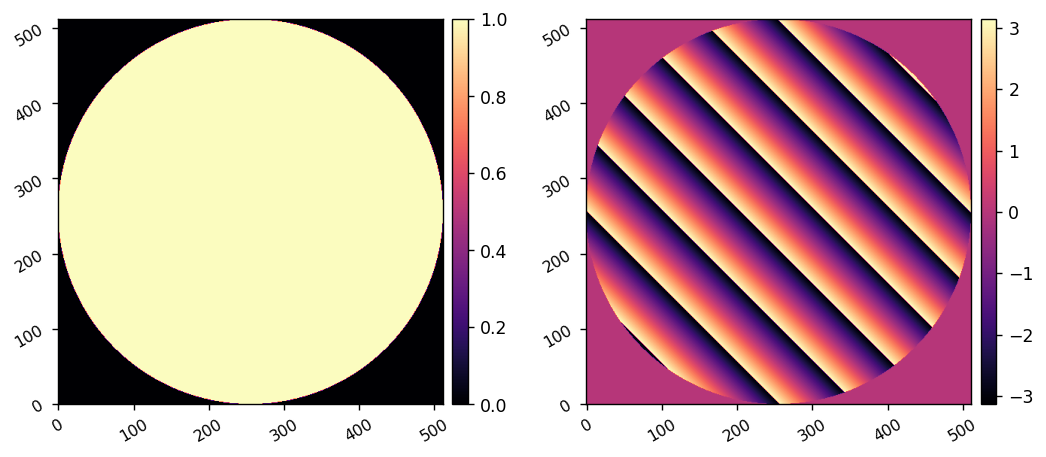

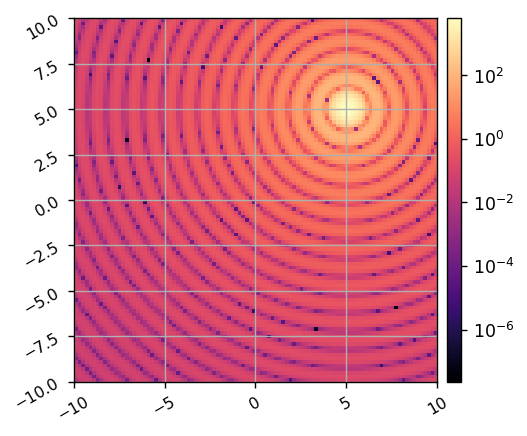

In [124]:
tilt_lamD = 5
tip_lamD = 5
delx = um_per_lamD.to(u.m) * tilt_lamD
dely = um_per_lamD.to(u.m) * tip_lamD
PV_tilt = pupil_diam * delx /fl
PV_tip = pupil_diam * dely /fl
rms_tilt = PV_tilt/3.98059244
rms_tip = PV_tip/3.98059244

tip_tilt = rms_tilt.to_value(u.m) * tip_tilt_modes[0] + rms_tip.to_value(u.m) * tip_tilt_modes[1]
pupil = ap * xp.exp(-1j*2*np.pi * tip_tilt/wavelength_c.value) 
fpwf = poppy.matrixDFT.matrix_dft(utils.pad_or_crop(pupil, npix), nlamD, npsf, inverse=False, centering='SYMMETRIC')
image = np.abs(fpwf)**2

imshow2(xp.abs(pupil), xp.angle(pupil), )
imshow1(image, lognorm=True, pxscl=psf_pixelscale_lamD, grid=True)

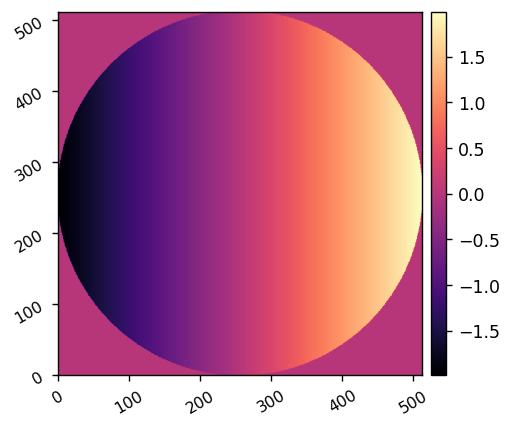

array(3.98059244)

In [94]:
imshow1(zmodes[0])
(xp.max(100*zmodes[0]) - xp.min(100*zmodes[0]))/rms(100*zmodes[0][model.pupil_mask])

In [37]:
model.WFE.opd.shape

(1,)

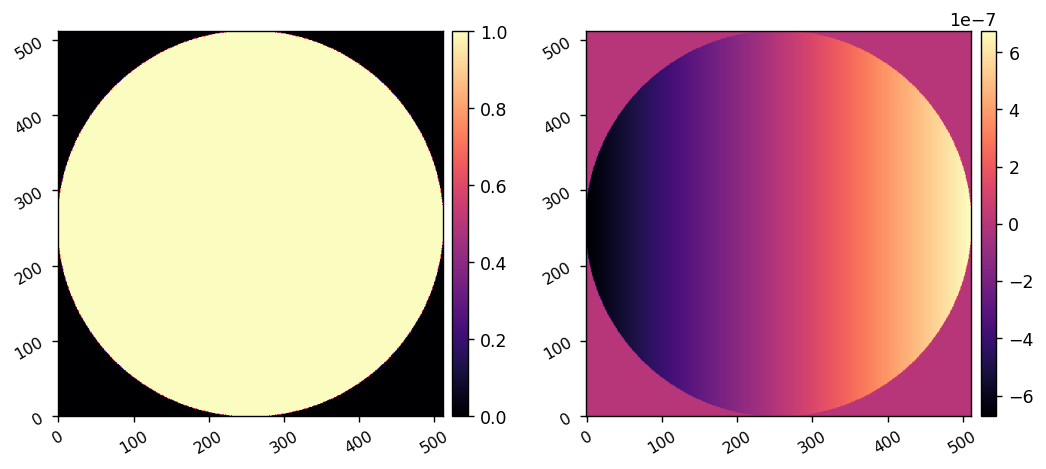

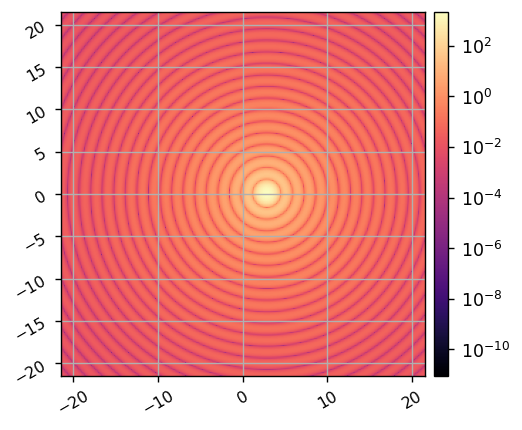

In [42]:
nmodes = 25
zmodes = lina.utils.create_zernike_modes(model.pupil_mask, nmodes=nmodes+1)[1:]

tip = 3.3810651e-07*utils.pad_or_crop(zmodes[0], model.N)
# tip = rms_tilt.to_value(u.m)*utils.pad_or_crop(zmodes[0], model.N)
# trefoil = 20e-9*utils.pad_or_crop(zmodes[7], model.N)

imshow2(model.pupil_mask, tip, npix=model.npix)

model.WFE.opd += tip
# model.WFE.opd += trefoil

im = model.snap()
imshow1(im, lognorm=True, grid=True, pxscl=model.psf_pixelscale_lamD)
model.reset_dm()

model.WFE.opd -= tip
# model.WFE.opd -=trefoil



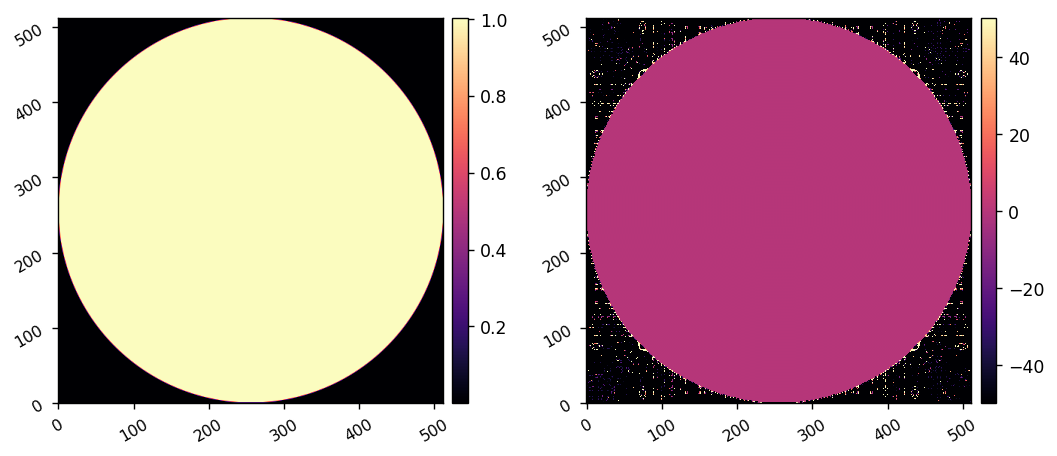

In [43]:
model.return_pupil = True
pupil_wf = model.calc_wf()
model.return_pupil = False
imshow2(xp.abs(pupil_wf), xp.angle(pupil_wf)*model.wavelength.to_value(u.nm)/(2*np.pi), 
        npix=model.npix, vmin2=-50, vmax2=50)


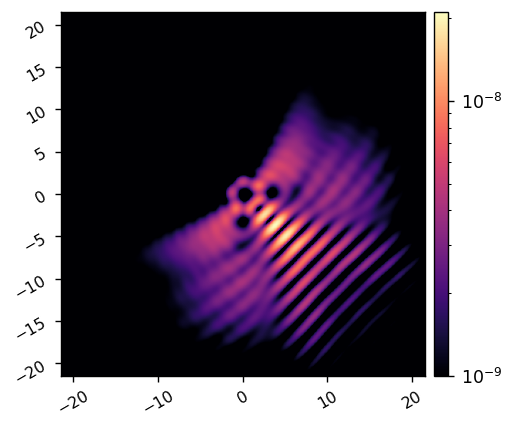

In [44]:
model.FPM = None
model.Imax_ref = model.snap().max()

ref_psf = model.snap()

model.FPM = vortex

ref_im = model.snap()
imshow1(ref_im, lognorm=True, vmin=1e-9, pxscl=model.psf_pixelscale_lamD)

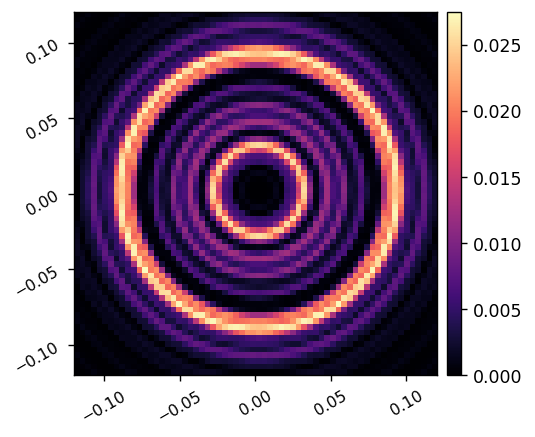

In [45]:
model.use_llowfsc = True
model.fl_llowfsc_lens = 200*u.mm
model.llowfsc_defocus = 1.75*u.mm
model.nllowfsc = 64

model.FPM = vortex
model.LYOT = wfs_lyot_stop

model.reset_dm()
im = model.snap()
imshow1(im, pxscl=model.llowfsc_pixelscale.to(u.mm/u.pix))


In [46]:
model.use_llowfsc = False
model.LYOT = lyot_stop
coro_im = model.snap()
model.use_llowfsc = True
model.LYOT = wfs_lyot_stop

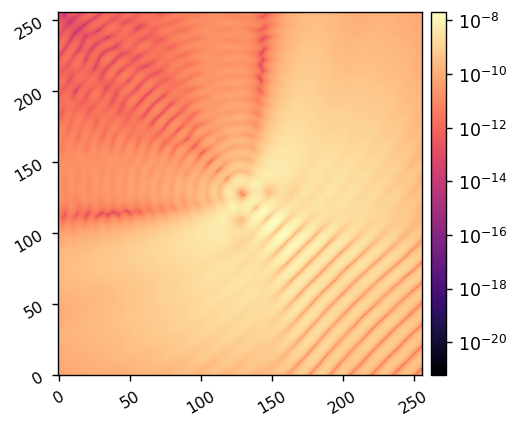

In [47]:
imshow1(coro_im, lognorm=True)

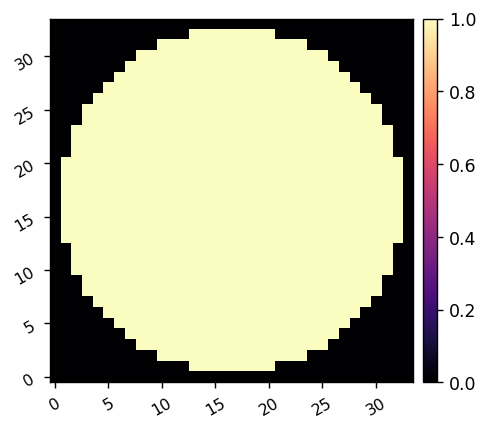

array(812)

In [48]:
dm_mask = xp.ones((model.Nact,model.Nact), dtype=bool)
xx = (xp.linspace(0, model.Nact-1, model.Nact) - model.Nact/2 + 1/2)
x,y = xp.meshgrid(xx,xx)
r = xp.sqrt(x**2 + y**2)
dm_mask[r>(model.Nact-2)/2] = 0
imshow1(dm_mask)
dm_mask.sum()

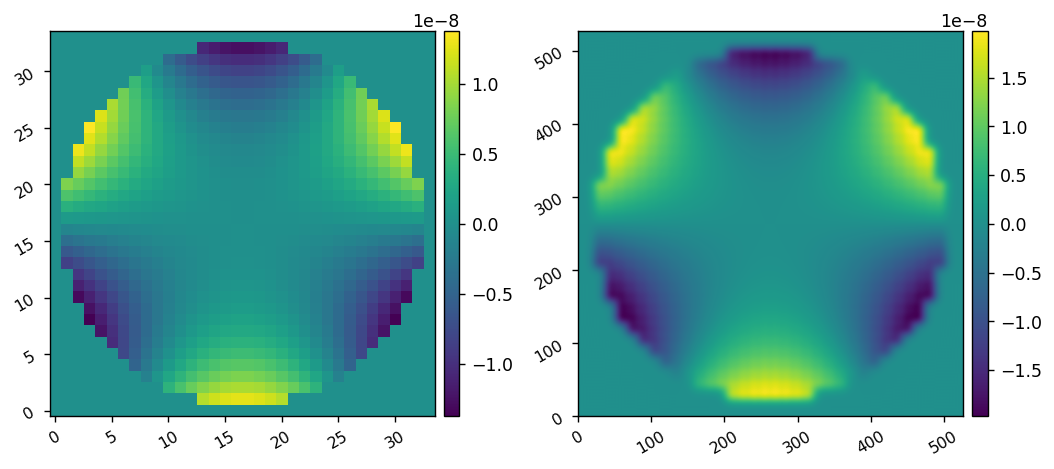

In [49]:
dm_zernikes = lina.utils.create_zernike_modes(dm_mask, nmodes=25 + 1)[1:]
model.set_dm(dm_zernikes[7]*5e-9)
imshow2(dm_zernikes[7]*5e-9, model.DM.get_surface(), cmap1='viridis', cmap2='viridis')
model.reset_dm()


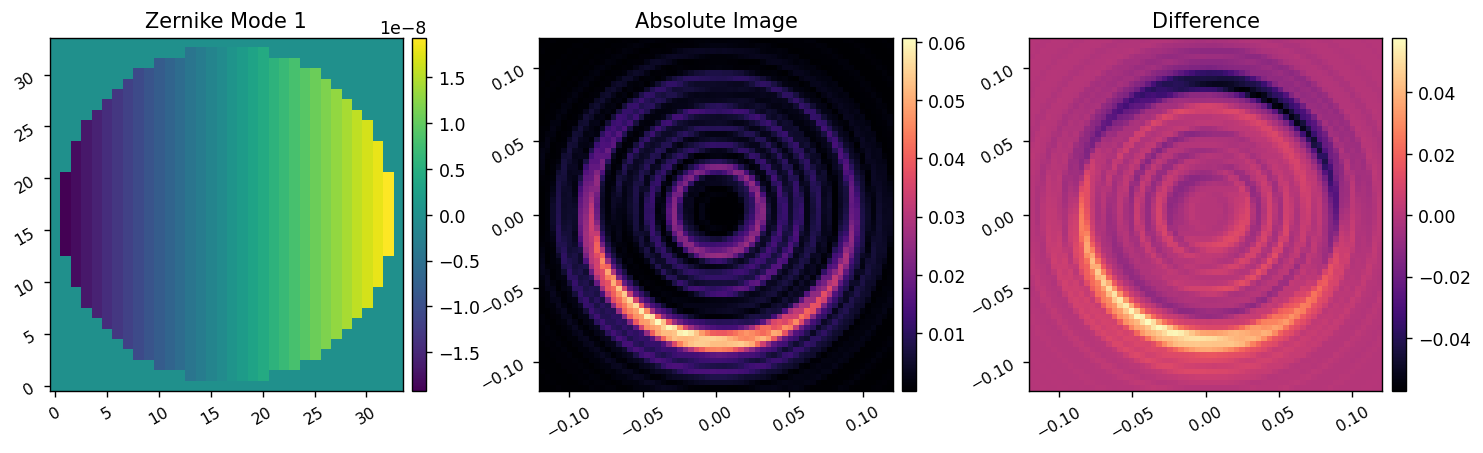

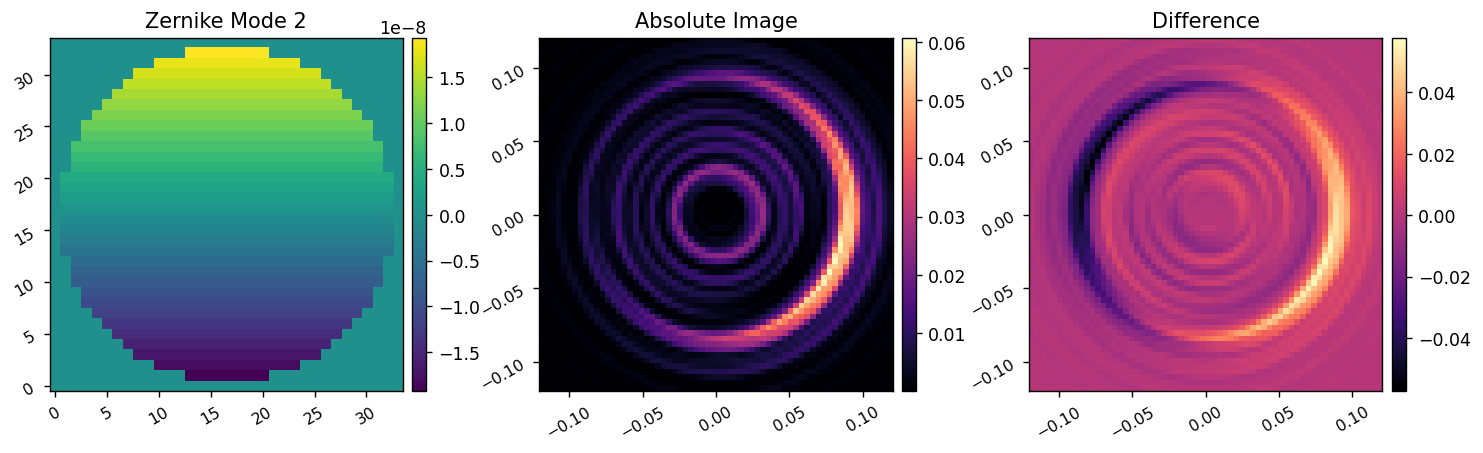

In [50]:
amp = 10e-9

im_ref = model.snap()

N = 2
responses = xp.zeros((N, model.nllowfsc**2))
for i in range(N):
    mode = dm_zernikes[i]
    # model.RETRIEVED = poppy.ArrayOpticalElement(opd=mode*1e-8, pixelscale=model.pupil_diam/(2*model.npix*u.pix))
    # im_pos = model.snap()

    model.set_dm(amp*mode)
    im_pos = model.snap()
    model.add_dm(-amp*mode)
    
    # diff = im_pos-im_ref
    # responses[i] = diff.flatten()/amp
    
    model.add_dm(-amp*mode)
    im_neg = model.snap()
    model.add_dm(amp*mode)

    diff = im_pos - im_neg
    responses[i] = diff.flatten()/(2*amp)

    imshow3(amp*mode, im_pos, diff, f'Zernike Mode {i+1}', 'Absolute Image', 'Difference', 
            pxscl2=model.llowfsc_pixelscale.to(u.mm/u.pix), pxscl3=model.llowfsc_pixelscale.to(u.mm/u.pix), 
            cmap1='viridis')

response_matrix = responses.T

In [51]:
U, s, Vt = xp.linalg.svd(response_matrix, full_matrices=False)
s.max()/s.min()

array(1.00005036)

In [52]:
# control_matrix = lina.utils.beta_reg(response_matrix, -10)
control_matrix = lina.utils.TikhonovInverse(response_matrix, 1e-15)

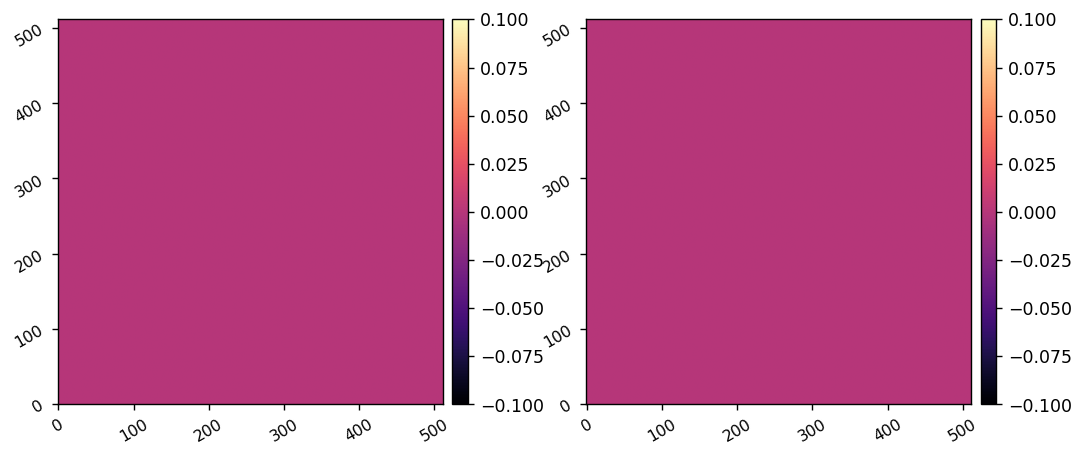

In [53]:
model.reset_dm()
model.WFE.opd = copy.copy(wfe_opd)
imshow2(wfe_opd, model.WFE.opd, npix=model.npix)

1.3432169502515583e-09 2.2349130310528265e-09
1.3432169502515583e-09 2.234913031052826e-09
2.6075022592152877e-09 2.6075022592152877e-09


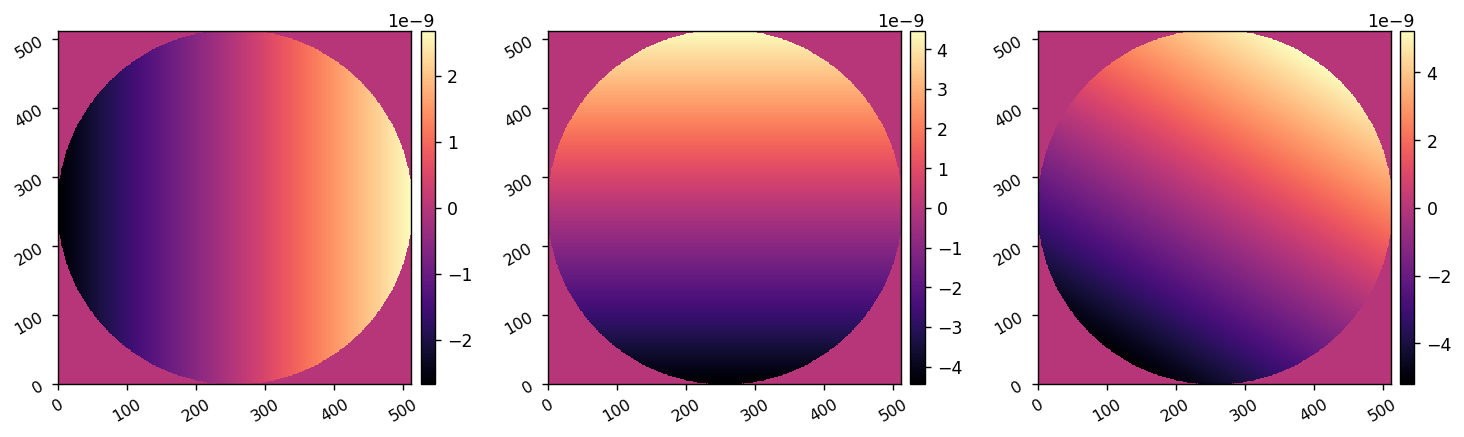

In [73]:
pointing_error_time_series = xp.array(fits.getdata('pointing_error_time_series.fits'))
times = pointing_error_time_series[0]
Nt = times.shape[0]
coeff = pointing_error_time_series[1:] * 1e-9

pointing_modes = copy.copy(zmodes[:2]).reshape(2, npix**2).T

i = 250
print(coeff[0,i], coeff[1,i])
tip = coeff[0,i]*pointing_modes[:,0].reshape(npix,npix)
tilt = coeff[1,i]*pointing_modes[:,1].reshape(npix,npix)
wfe = pointing_modes.dot(xp.array(coeff[:,i])).reshape(npix,npix)

print(np.sqrt(np.mean(np.square(tip[model.pupil_mask]))), np.sqrt(np.mean(np.square(tilt[model.pupil_mask]))))
print(xp.sqrt(coeff[0,i]**2 + coeff[1,i]**2), np.sqrt(np.mean(np.square(wfe[model.pupil_mask]))))
imshow3(tip, tilt, wfe)


In [74]:
print(np.sqrt(np.mean(np.square(coeff[0]))), np.sqrt(np.mean(np.square(coeff[1]))))

offset = np.sqrt(coeff[0]**2 + coeff[1]**2)
print(np.sqrt(np.mean(np.square(offset))))

1e-08 2e-08
2.2360679774997898e-08


In [75]:

rmss = xp.zeros(Nt)
for i in range(len(times)):
    wfe = pointing_modes.dot(coeff[:,i]).reshape(npix,npix)
    rmss[i] = xp.sqrt(xp.mean(xp.square(wfe[model.pupil_mask])))


In [76]:
xp.sqrt(xp.mean(xp.square(rmss)))

array(2.23606798e-08)

In [60]:
N = 100
wfe_times = xp.zeros(N)
pointing_wfe = xp.zeros((N, npix, npix))
for i in range(N):
    a = xp.array(coeff[:,10*i])
    wfe = pointing_modes.dot(a).reshape(npix,npix)
    pointing_wfe[i] = wfe
    wfe_times[i] = times[10*i]
    # imshow1(wfe)

In [24]:
times

array([0.000000e+00, 5.000000e-03, 1.000000e-02, ..., 2.621425e+03,
       2.621430e+03, 2.621435e+03])

In [61]:
import matplotlib.pyplot as plt
plt.rcParams['image.origin']='lower'

import matplotlib
from matplotlib.animation import FFMpegWriter, PillowWriter
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['animation.html'] = 'html5'
plt.rcParams.update({'image.origin': 'lower',
                     'image.interpolation':'nearest'})

def create_anim(arrs1):
    numframes = arrs1.shape[0]
    print(numframes)

    fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(5,5),dpi=125)
    
    im1 = ax.imshow(arrs1[0,:,:],)
    im1_title = ax.set_title(f'WFE: Time = {0.0:.2e}s', fontsize = 18)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="4%", pad=0.075)
    cbar = fig.colorbar(im1, cax=cax)

    def animate(i):
        im1.set_data(arrs1[i,:,:])
        im1_title.set_text(f'WFE: Time = {wfe_times[i]:.2e}s')
        im1.set_clim(vmin=np.min(arrs1[i,:,:]), vmax=np.max(arrs1[i,:,:]))

    anim = matplotlib.animation.FuncAnimation(fig, animate, frames=numframes, )
    return anim

100
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:figure size in inches has been adjusted from 5.0 x 5.0 to 4.992 x 4.992
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 624x624 -pix_fmt rgba -r 5.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp_es4xcmo/temp.m4v


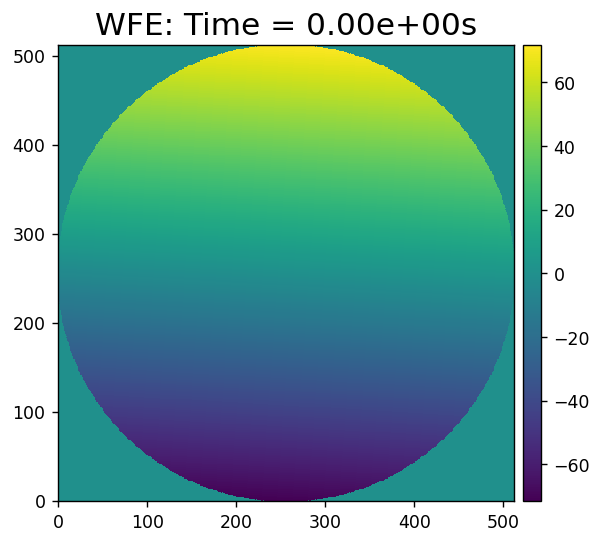

In [62]:
create_anim(pointing_wfe.get())

In [138]:
control_matrix[:2].shape

(2, 4096)

In [65]:
reload(lina.llowfsc)
lina.llowfsc.run_model

<function lina.llowfsc.run_model(sysi, ref_im, control_matrix, control_modes, time_series_coeff, zernike_modes, lyot_stop=None, reverse_dm_parity=False, plot=False)>

In [67]:
from scoobpsf import imshows
reload(imshows)


<module 'scoobpsf.imshows' from '/home/kianmilani/Projects/scoob-psf/scoobpsf/imshows.py'>

In [69]:
zmodes[:N].shape

(25, 512, 512)

(1156, 2) (262144, 2)
1
(512, 512) (512, 512)


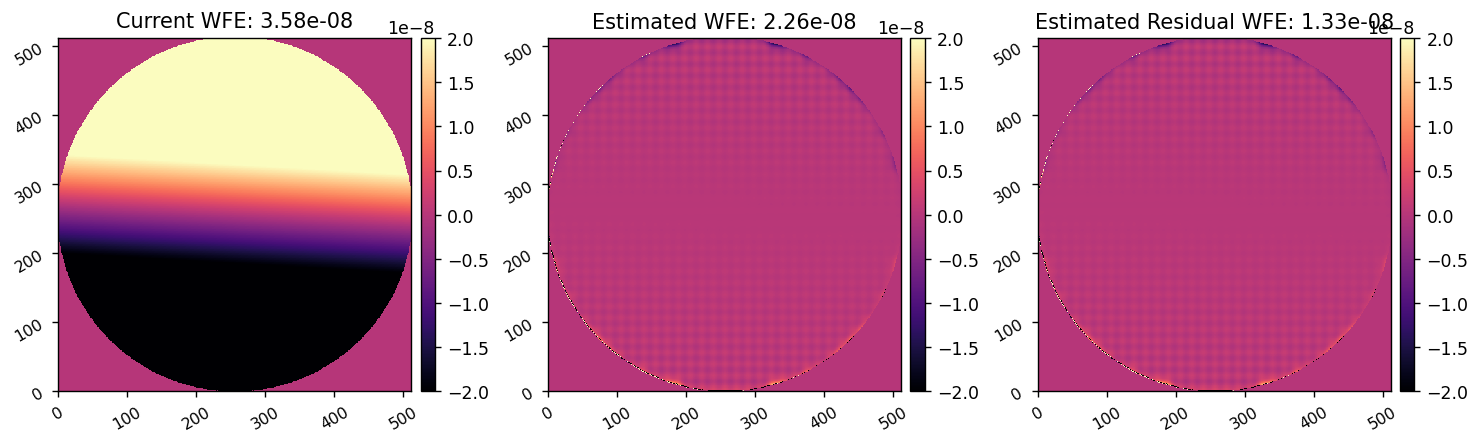

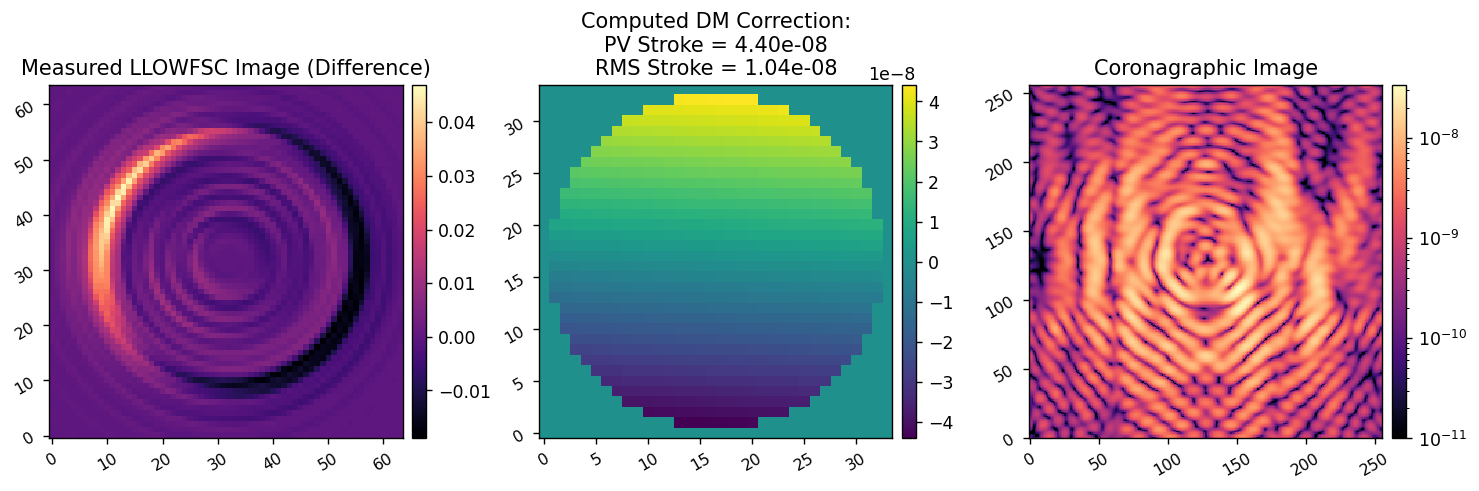

1
(512, 512) (512, 512)


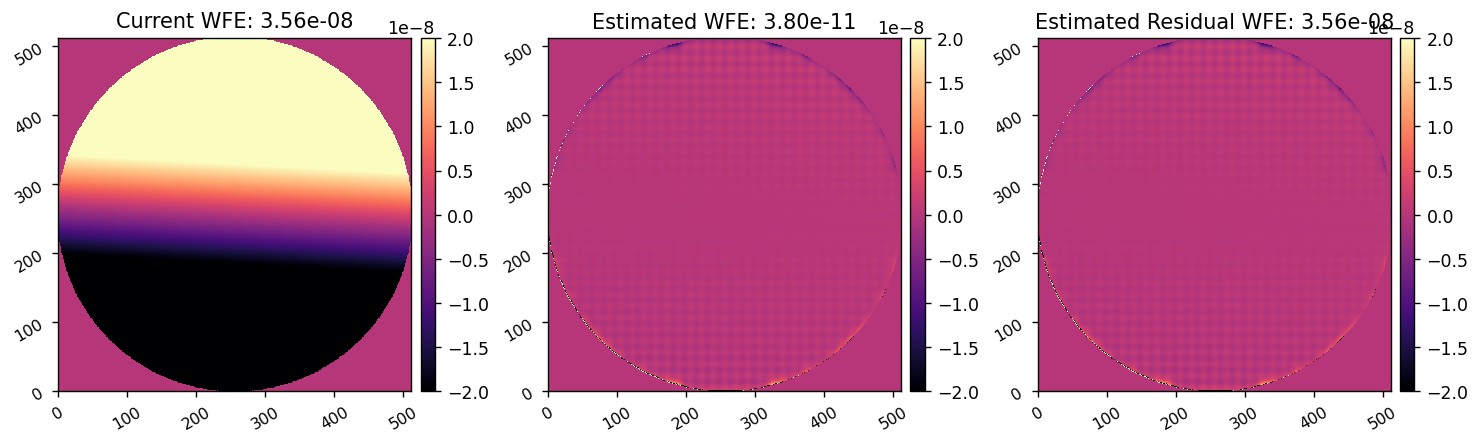

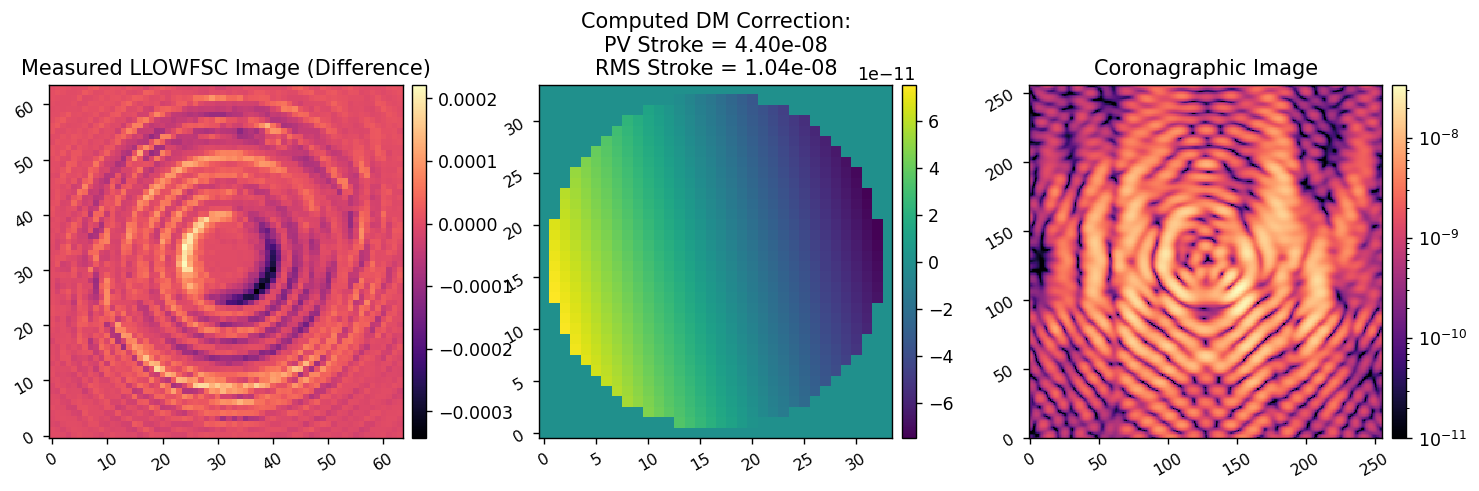

1
(512, 512) (512, 512)


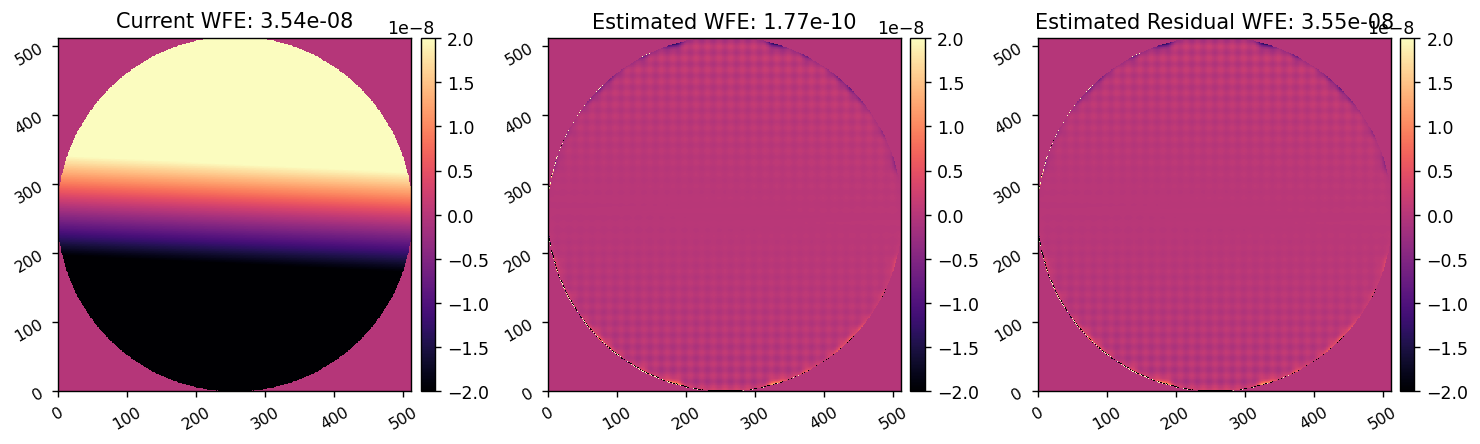

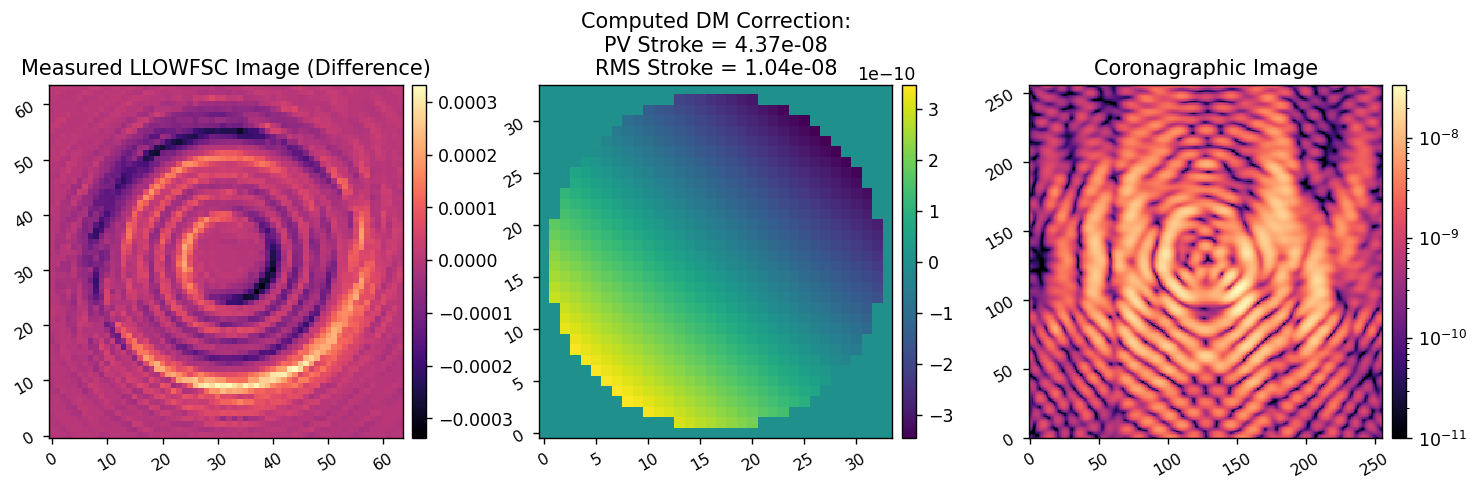

1
(512, 512) (512, 512)


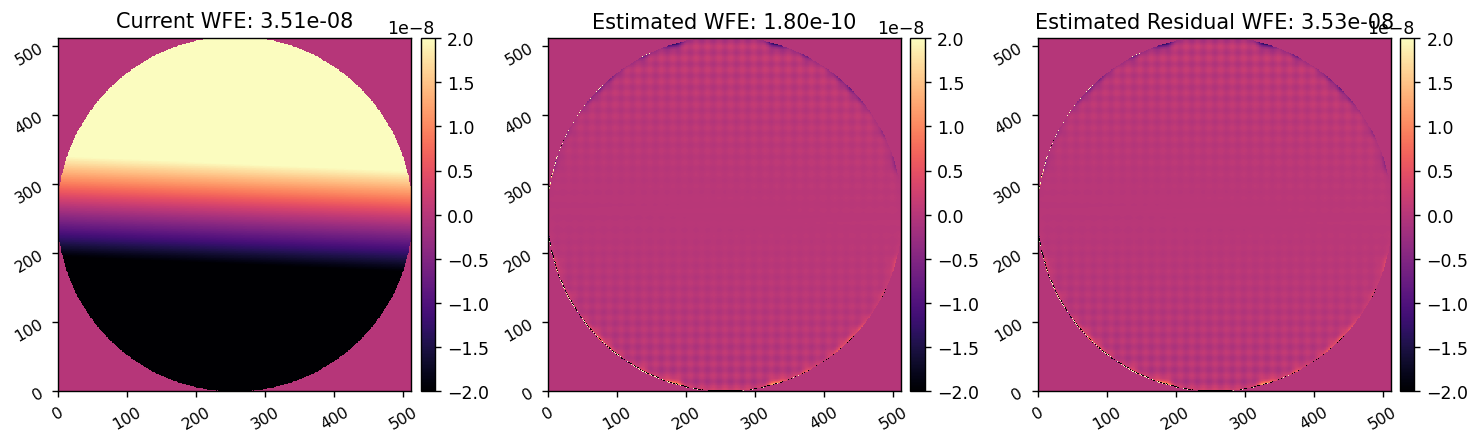

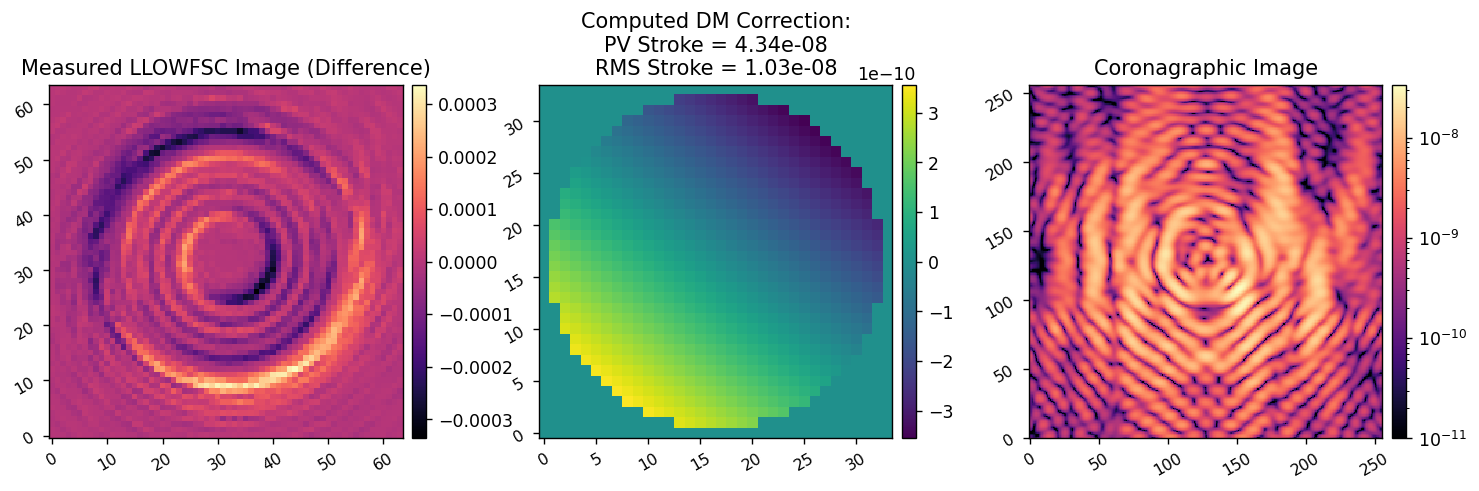

1
(512, 512) (512, 512)


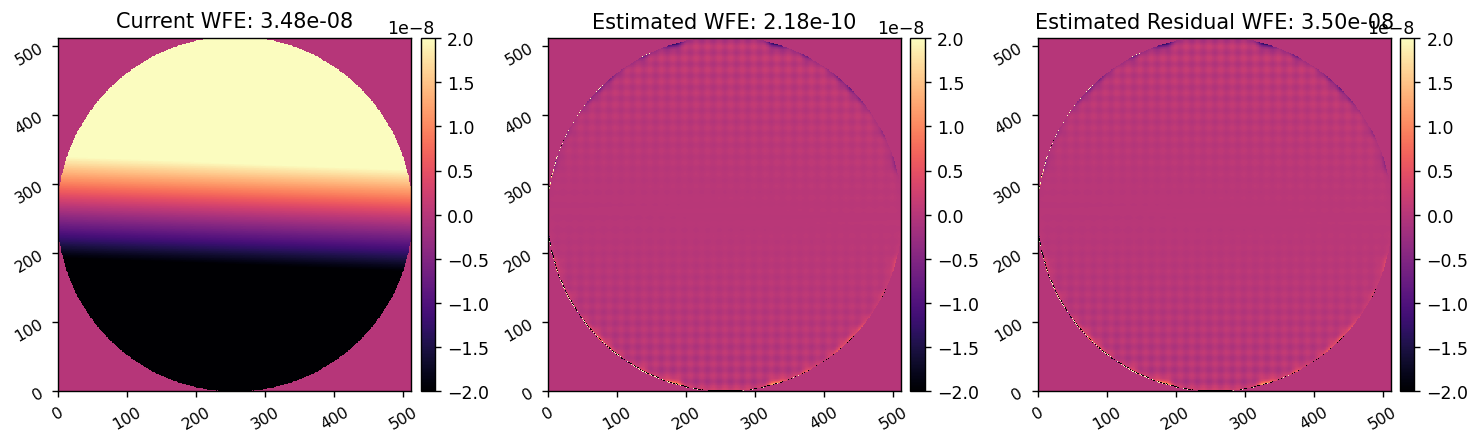

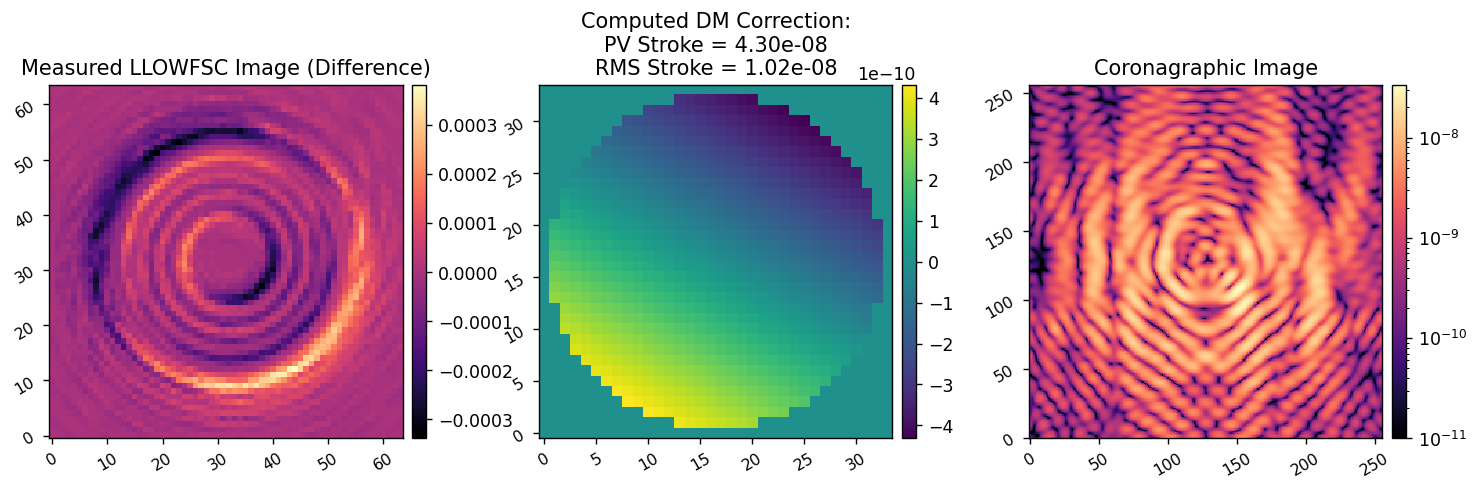

1
(512, 512) (512, 512)


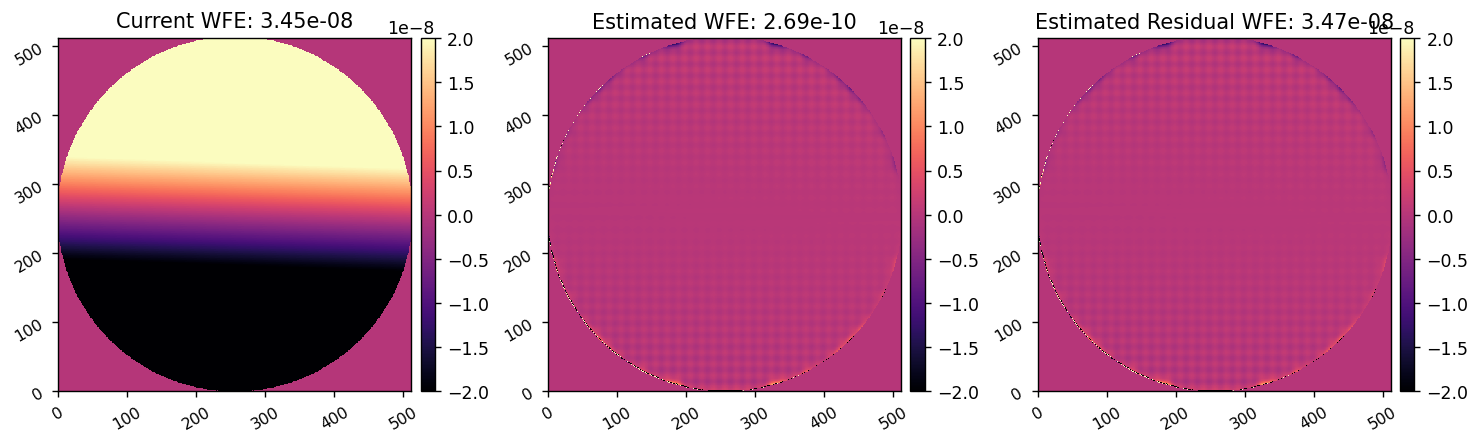

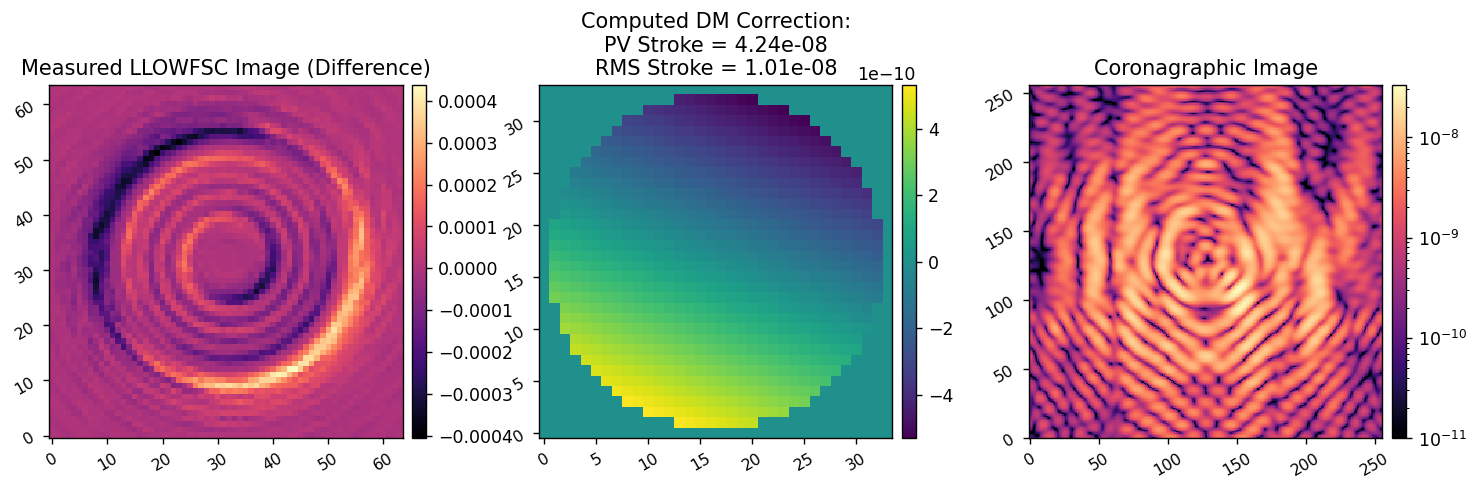

1
(512, 512) (512, 512)


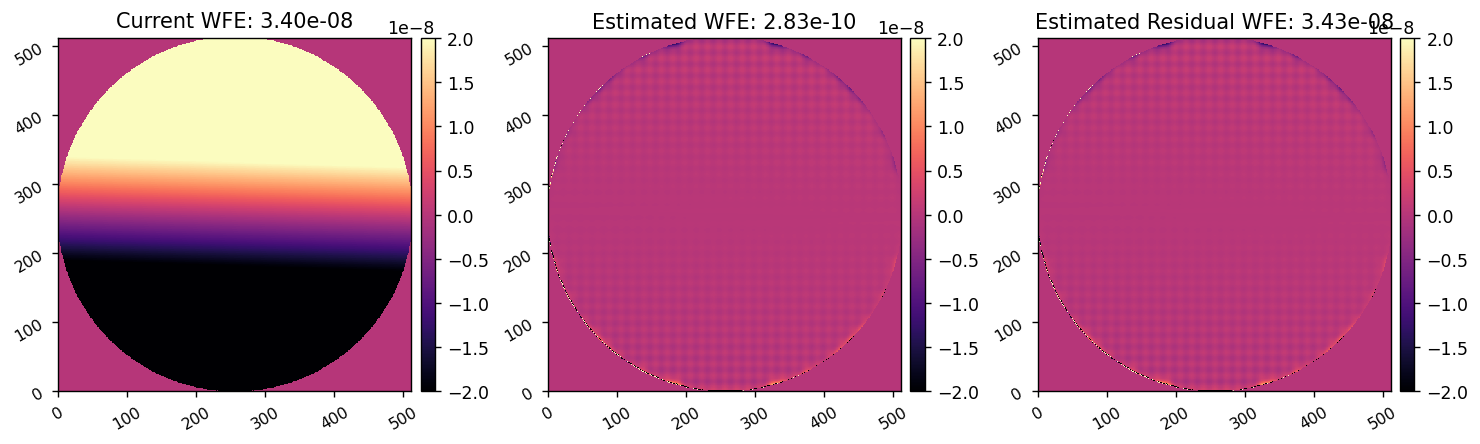

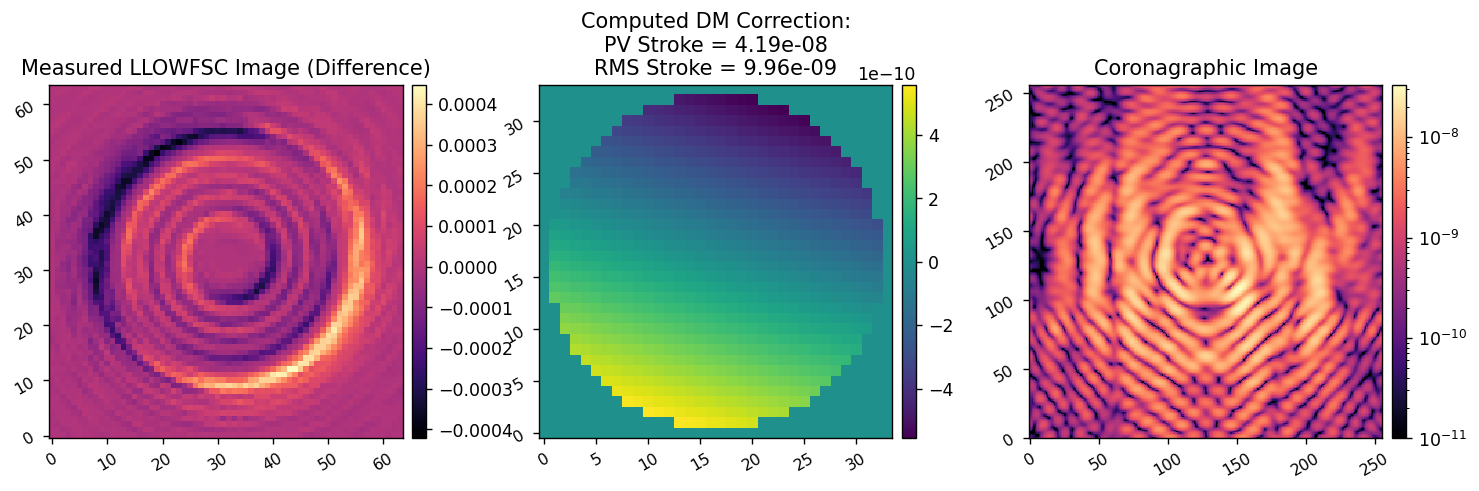

1
(512, 512) (512, 512)


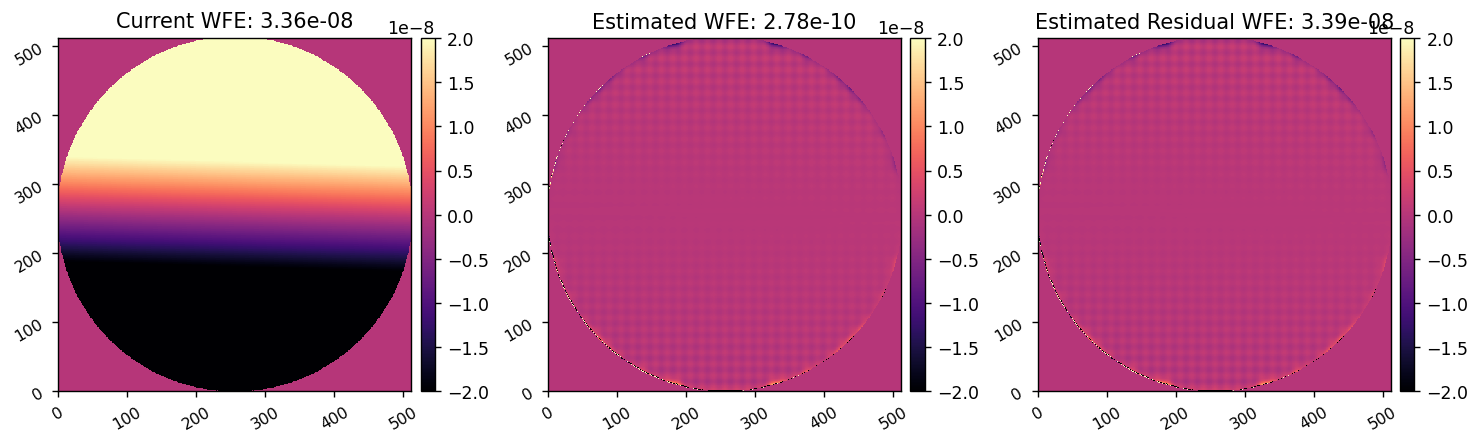

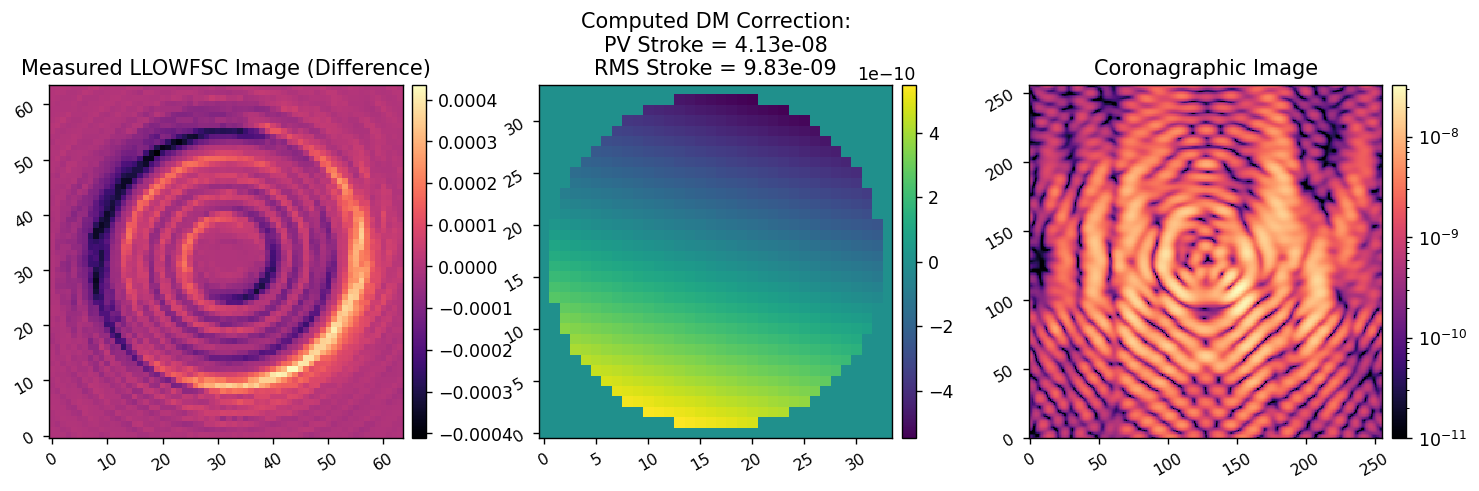

1
(512, 512) (512, 512)


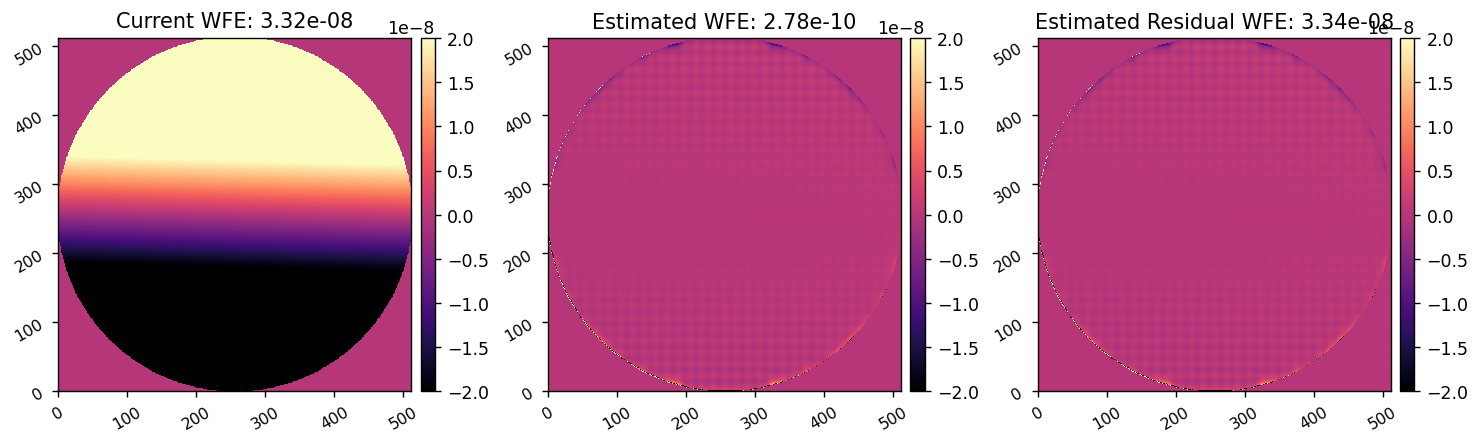

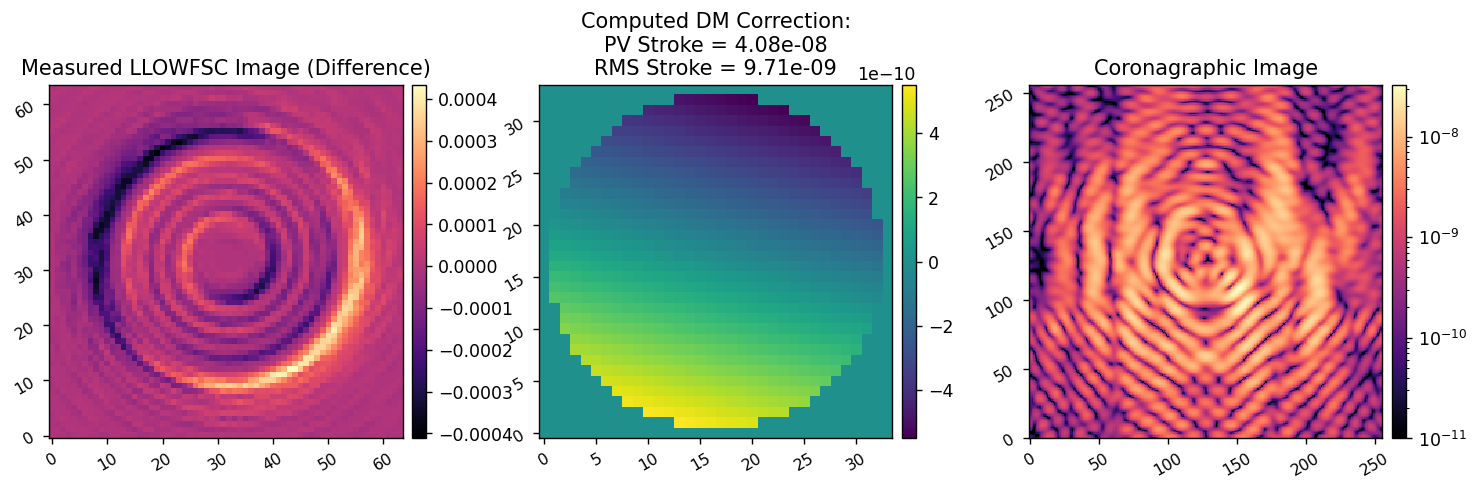

1
(512, 512) (512, 512)


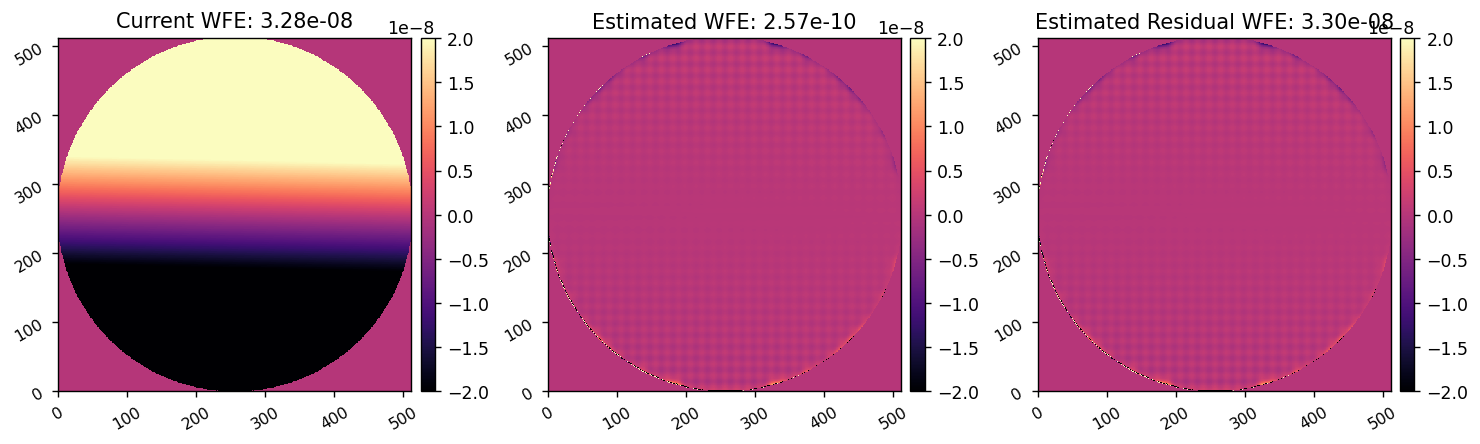

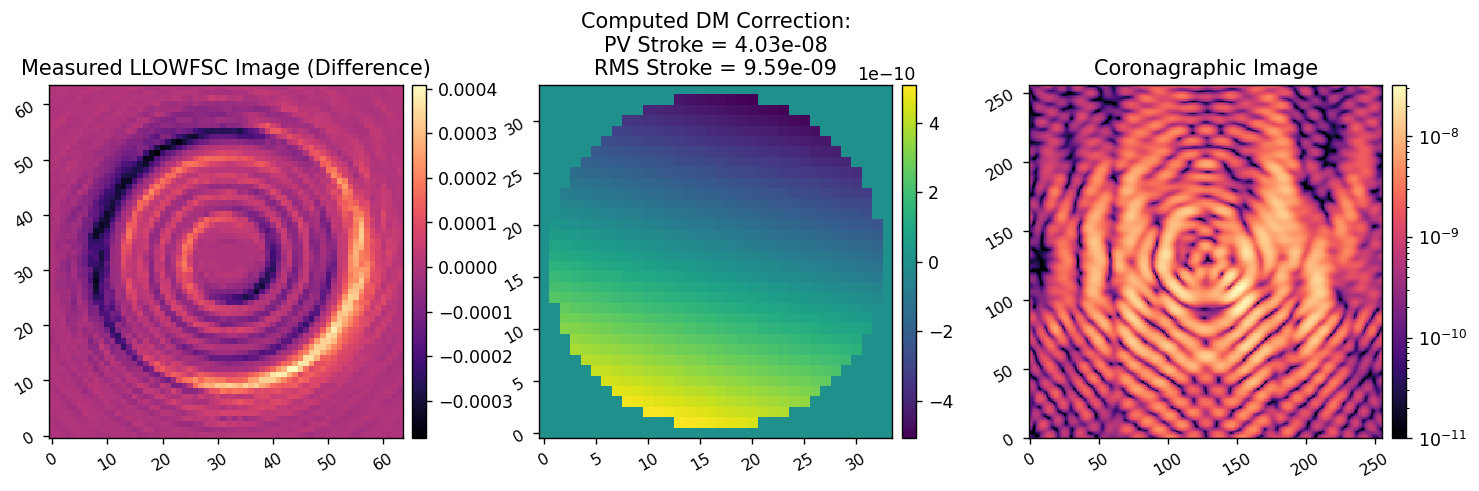

In [79]:
reload(lina)
reload(lina.llowfsc)

Ncoeff = 10
N = 2

model.reset_dm()
model.WFE.opd = copy.copy(wfe_opd)

lina.llowfsc.run_model(model, 
                      ref_im=im_ref, 
                      control_matrix=control_matrix[:N], 
                      control_modes=dm_zernikes[:N],
                      time_series_coeff=coeff[:,:Ncoeff], 
                      zernike_modes=zmodes[:N], 
                      plot=True, 
                      )

In [100]:
dm_comb_mask = xp.zeros((model.npix, model.npix))
spacing = npix//34
inds = ((xp.linspace(0, (34-1), 34 ) + 1/2) *spacing - 1/2).astype(int)
inds
dm_comb_mask[inds:inds,inds:inds] = 1

imshow1(dm_comb_mask, npix=128)

TypeError: slice.start must be int or None or have __index__ method: slice(array([  7,  22,  37,  52,  67,  82,  97, 112, 127, 142, 157, 172, 187,
       202, 217, 232, 247, 262, 277, 292, 307, 322, 337, 352, 367, 382,
       397, 412, 427, 442, 457, 472, 487, 502]), array([  7,  22,  37,  52,  67,  82,  97, 112, 127, 142, 157, 172, 187,
       202, 217, 232, 247, 262, 277, 292, 307, 322, 337, 352, 367, 382,
       397, 412, 427, 442, 457, 472, 487, 502]), None)

In [101]:
inds:inds

In [53]:
delt = times[1]-times[0]
1/delt

array(200.)

In [ ]:
create_anim(ensure_np_array(pointing_wfe))